# Introduction
Throughout this document, we will implement various regression and/or classification models for the OSA case study

# Nested-Cross validation implementation
First we need to install and import the following libraries

In [ ]:
!pip install pandas scikit-learn numpy scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.3 MB/s eta 0:00:00


In [ ]:
%reset -f

from google.colab import files
import io

import pandas as pd
import numpy as np
import math

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

We load the cleaned dataframe obtained in R

In [ ]:
%rm df_final.csv

uploaded = files.upload()
df_regression = pd.read_csv(io.BytesIO(uploaded['df_final.csv']))

rm: cannot remove 'df_final.csv': No such file or directory


Saving df_final.csv to df_final.csv


Once the data frame is loaded, we need to encode 'Gender' attribute. We also want to keep just those arguments that were detected as relevant in our EDA, by deleting "Patient", "Height", and the non-numeric additional columns, such as "Smoker", "Snorer" and "Illnesses"

In [ ]:
df_regression['Gender'] = df_regression['Gender'].replace({'male': 1 ,'female': 0})
del df_regression['Patient'], df_regression['Height'], df_regression['Illnesses'], df_regression['Smoker'], df_regression['Snorer']

In [ ]:
df_regression

,Gender,Weight,Age,Cervical,BMI,AHI
0,1,119,56,48.0,39.31,29.6
1,1,78,39,42.0,27.64,19.7
2,1,80,32,40.0,26.73,9.0
3,1,109,32,42.0,30.19,2.0
4,1,86,39,42.0,30.11,34.0
...,...,...,...,...,...,...
618,0,82,64,39.0,30.12,36.3
619,1,105,35,45.0,32.41,9.2
620,1,90,50,42.0,27.78,52.2
621,0,66,57,35.0,24.54,5.4


Split data into features (X) and target variable (Y_true)

In [ ]:
X = df_regression[[col for col in df_regression.columns if col != "AHI"]].to_numpy()
Y_true = df_regression[["AHI"]].to_numpy().ravel()

Create scorer to evaluate the performance of the model.
In our case we are going to use Mean Absolute Error (MAE) metric as it is more robust to outliers.

In [ ]:
mae_scorer = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better=False)


Definition of the cross validation k-folds function:
implements a nested cross-validation procedure for selecting and evaluating machine learning models, employing an outer loop to split the data into training and test sets, and an inner loop to perform hyperparameter tuning through cross-validation. It aims to provide the best-performing model, its optimal hyperparameters, and assess its performance using regression metrics. This process is repeated iteratively for robust model evaluation across various data splits.

In [ ]:
def nested_kfolds(X, y, model, space, scorer):
    OUTER_SPLITS = 3
    INNER_SPLITS = 3
    N_ITER = 50
    N_JOBS = 10
    N_POINTS = 10

    cv_outer = KFold(n_splits=OUTER_SPLITS, shuffle=True, random_state=1)
    outer_results = {"mae": list(), "rmse": list(), "r2": list()}
    final_best_model = None
    final_best_params = None
    max_score = float("-inf")

    for train_ix, test_ix in cv_outer.split(X):
        scaler = StandardScaler()
        pipeline = Pipeline([('scaler', scaler), ('model', model)])

        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        if not space:
            best_model = pipeline.fit(X_train, y_train)
            score = scorer(best_model, X_test, y_test)

            # Store the results for every important regression metric
            y_pred = best_model.predict(X_test)
            outer_results["mae"].append(metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred))
            outer_results["rmse"].append(math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=y_pred)))
            outer_results["r2"].append(metrics.r2_score(y_true=y_test, y_pred=y_pred))

            # Report progress
            print('>Score=%.3f, est=%.3f, cfg=%s' % (score, float("nan"), "Not applied"))

            # Update the best model
            if score > max_score:
                max_score = score
                final_best_model = best_model
                final_best_params = {}

        else:
            cv_inner = KFold(n_splits=INNER_SPLITS, shuffle=True, random_state=1)
            search = BayesSearchCV(model, space, scoring=scorer, cv=cv_inner, refit=True, n_iter=N_ITER, n_jobs=N_JOBS, n_points=N_POINTS)
            result = search.fit(X_train, y_train)

            best_model = result.best_estimator_

            # Evaluate the model
            score = scorer(best_model, X_test, y_test)

            # Store the results for every important regression metric
            y_pred = best_model.predict(X_test)
            outer_results["mae"].append(metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred))
            outer_results["rmse"].append(math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=y_pred)))
            outer_results["r2"].append(metrics.r2_score(y_true=y_test, y_pred=y_pred))

            # Report progress
            print('>Score=%.3f, est=%.3f, cfg=%s' % (score, result.best_score_, result.best_params_))

            # Update the best model
            if score > max_score:
                max_score = score
                final_best_model = best_model
                final_best_params = result.best_params_

    # Summarize the estimated performance of the model
    avg_score, std_score = dict(), dict()
    for key, value in outer_results.items():
        avg_score[key], std_score[key] = np.nanmean(value), np.nanstd(value)
        print('%s: %.3f (%.3f)' % (key, avg_score[key], std_score[key]))

    return final_best_model, final_best_params, avg_score, std_score


# Linear regression
Once the nested_kfolds function is defined, we can procedure with the training of the different models.
'space' argument is empty because we are using a linear regression model and it does not have hyperparameters to tune.

In [ ]:
from sklearn.linear_model import LinearRegression

linear_regression_model = LinearRegression()

final_model, final_params, avg_scores, std_scores = nested_kfolds(X, Y_true, linear_regression_model, {}, mae_scorer)

>Score=-11.893, est=nan, cfg=Not applied
>Score=-12.988, est=nan, cfg=Not applied
>Score=-12.578, est=nan, cfg=Not applied
mae: 12.486 (0.452)
rmse: 16.610 (0.911)
r2: 0.203 (0.014)


# k-NN


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

kNN_model = KNeighborsRegressor()

space = {
    'n_neighbors': (1, 10),
    'weights': ['uniform', 'distance'],
}

final_best_model, final_best_params, avg_score, std_score = nested_kfolds(X, Y_true, kNN_model, space, mae_scorer)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-12.169, est=-13.005, cfg=OrderedDict([('n_neighbors', 10), ('weights', 'uniform')])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-12.904, est=-12.780, cfg=OrderedDict([('n_neighbors', 10), ('weights', 'uniform')])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-12.734, est=-12.952, cfg=OrderedDict([('n_neighbors', 10), ('weights', 'uniform')])
mae: 12.602 (0.314)
rmse: 16.859 (0.807)
r2: 0.178 (0.020)


# Decission Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Real, Categorical, Integer

decision_tree_model = DecisionTreeRegressor()

space = {
  'ccp_alpha': Real(0, 1)
}

final_best_model, final_best_params, avg_score, std_score = nested_kfolds(X, Y_true, decision_tree_model, space, mae_scorer)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-14.332, est=-15.610, cfg=OrderedDict([('ccp_alpha', 0.6847190453470625)])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-15.537, est=-16.837, cfg=OrderedDict([('ccp_alpha', 0.9999993238310826)])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-15.236, est=-15.701, cfg=OrderedDict([('ccp_alpha', 1.0)])
mae: 15.035 (0.512)
rmse: 21.595 (0.944)
r2: -0.350 (0.043)


Alpha (cpp=cost complexity) controls the trade-off between subtree's complexity and fitness of the data

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor()

space = {
    'n_estimators': Integer(100, 1000),
    'max_samples': Real (0.2 , 0.4) ,
    'max_features': Real (0.6 , 0.8)

}

final_best_model, final_best_params, avg_score, std_score = nested_kfolds(X, Y_true, random_forest_model, space, mae_scorer)

>Score=-11.711, est=-12.723, cfg=OrderedDict([('max_features', 0.6036858000509643), ('max_samples', 0.39183149518784127), ('n_estimators', 243)])
>Score=-12.931, est=-12.533, cfg=OrderedDict([('max_features', 0.6057853143200638), ('max_samples', 0.22581154922623026), ('n_estimators', 100)])
>Score=-12.219, est=-12.333, cfg=OrderedDict([('max_features', 0.6), ('max_samples', 0.2268175927510519), ('n_estimators', 100)])
mae: 12.287 (0.501)
rmse: 16.291 (0.839)
r2: 0.233 (0.019)


# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

adaboost_model = AdaBoostRegressor()

space = {
    'n_estimators': Integer(50, 1000),
}

final_best_model, final_best_params, avg_score, std_score = nested_kfolds(X, Y_true, adaboost_model, space, mae_scorer)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-13.664, est=-14.223, cfg=OrderedDict([('n_estimators', 660)])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-16.092, est=-13.613, cfg=OrderedDict([('n_estimators', 926)])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-15.032, est=-13.707, cfg=OrderedDict([('n_estimators', 620)])
mae: 14.929 (0.994)
rmse: 18.060 (0.979)
r2: 0.056 (0.055)


# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()

space = {
    'learning_rate': Real(0.01, 1.0),
}

final_best_model, final_best_params, avg_score, std_score = nested_kfolds(X, Y_true, model, space, mae_scorer)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


>Score=-11.490, est=-12.703, cfg=OrderedDict([('learning_rate', 0.04690520777472556)])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-12.505, est=-12.557, cfg=OrderedDict([('learning_rate', 0.021038954725634752)])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-12.324, est=-12.540, cfg=OrderedDict([('learning_rate', 0.02733078736699683)])
mae: 12.106 (0.442)
rmse: 16.071 (0.650)
r2: 0.252 (0.030)


# Lasso


In [ ]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()

space = {
    'alpha': Real(1e-3, 1),
}

final_best_model, final_best_params, avg_score, std_score = nested_kfolds(X, Y_true, lasso_model, space, mae_scorer)


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-11.804, est=-12.937, cfg=OrderedDict([('alpha', 1.0)])
>Score=-12.902, est=-12.287, cfg=OrderedDict([('alpha', 0.6001779344738263)])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


>Score=-12.621, est=-12.193, cfg=OrderedDict([('alpha', 1.0)])
mae: 12.442 (0.466)
rmse: 16.531 (0.970)
r2: 0.211 (0.006)


# Ridge

In [ ]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

space = {
    'alpha': Real(1e-3, 1),
}

final_best_model, final_best_params, avg_score, std_score = nested_kfolds(X, Y_true, ridge_model, space, mae_scorer)


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


>Score=-11.891, est=-13.093, cfg=OrderedDict([('alpha', 1.0)])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


>Score=-12.986, est=-12.433, cfg=OrderedDict([('alpha', 1.0)])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-12.577, est=-12.194, cfg=OrderedDict([('alpha', 1.0)])
mae: 12.485 (0.452)
rmse: 16.607 (0.911)
r2: 0.203 (0.014)


# ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet

elasticnet_model = ElasticNet()

space = {
    'l1_ratio': Real(0.01, 1.0),
}

final_best_model, final_best_params, avg_score, std_score = nested_kfolds(X, Y_true, elasticnet_model, space, mae_scorer)


>Score=-11.806, est=-12.935, cfg=OrderedDict([('l1_ratio', 0.6161421265015525)])
>Score=-12.899, est=-12.295, cfg=OrderedDict([('l1_ratio', 0.6093702791839876)])
>Score=-12.608, est=-12.193, cfg=OrderedDict([('l1_ratio', 0.6535039200504803)])
mae: 12.438 (0.462)
rmse: 16.527 (0.966)
r2: 0.211 (0.007)


# SVR

In [ ]:
from sklearn.svm import SVR

svr_model = SVR()

space_svr = {
    'C': Real(1e-3, 1),
    'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
}

final_best_model_svr, final_best_params_svr, avg_score_svr, std_score_svr = nested_kfolds(X, Y_true, svr_model, space_svr, mae_scorer)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-11.358, est=-12.338, cfg=OrderedDict([('C', 1.0), ('kernel', 'poly')])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-12.067, est=-11.862, cfg=OrderedDict([('C', 1.0), ('kernel', 'poly')])


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

>Score=-12.560, est=-11.662, cfg=OrderedDict([('C', 0.545346184796362), ('kernel', 'poly')])
mae: 11.995 (0.493)
rmse: 17.066 (1.219)
r2: 0.160 (0.032)


# Recap

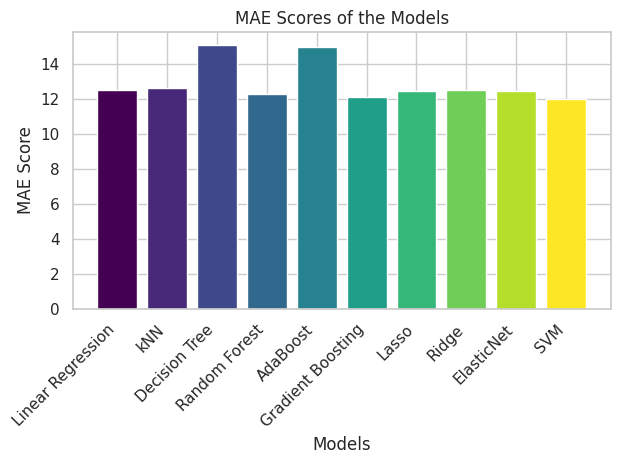

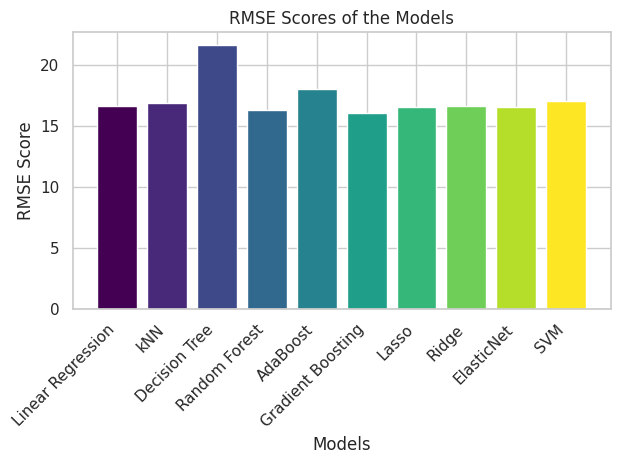

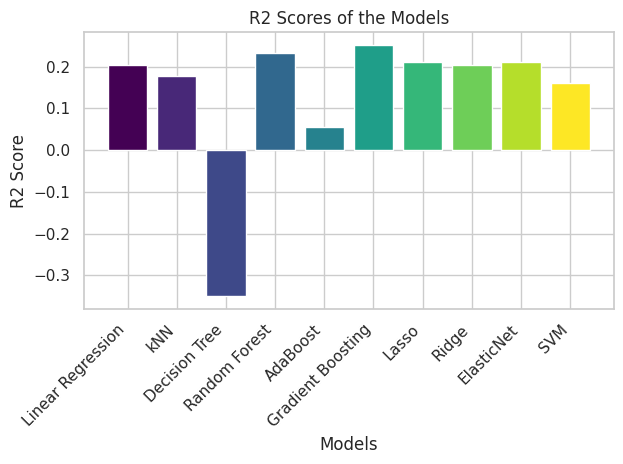

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
modelos = ['Linear Regression', 'kNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'Lasso', 'Ridge', 'ElasticNet', 'SVM']
mae_scores = [12.486, 12.602, 15.035, 12.287, 14.929, 12.071, 12.442, 12.485, 12.438, 11.995]
rmse_scores = [16.610, 16.859, 21.595, 16.291, 18.060, 16.071, 16.531, 16.607, 16.527, 17.066]
r2_scores = [0.203, 0.178, -0.350, 0.233, 0.056, 0.252, 0.211, 0.203, 0.211, 0.160]

# Colores para las barras
colores = plt.cm.viridis(np.linspace(0, 1, len(modelos)))

# Gráfico de barras para MAE
plt.bar(modelos, mae_scores, color=colores)
plt.xlabel('Models')
plt.ylabel('MAE Score')
plt.title('MAE Scores of the Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('mae_scores.png')
plt.show()

# Gráfico de barras para RMSE
plt.bar(modelos, rmse_scores, color=colores)
plt.xlabel('Models')
plt.ylabel('RMSE Score')
plt.title('RMSE Scores of the Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('rmse_scores.png')
plt.show()

# Gráfico de barras para R2
plt.bar(modelos, r2_scores, color=colores)
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('R2 Scores of the Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('r2_scores.png')
plt.show()
